# Machine Learning - Prediction of HDB price

In [1]:
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.externals import joblib

import warnings
warnings.filterwarnings("ignore")

C:\Users\andre\AppData\Local\Continuum\anaconda3\envs\streamprophet37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### Load Data

As mentioned in the EDA section, only data from 2013 will be used.

The feature storey_range is changed from a categorical feature to a numerical feature by using the mid-value of the range.

In [2]:
df=pd.read_csv("data.csv")
df=df[df["year_sold"]>=2013].reset_index(drop=True)

storey_df=df["storey_range"].str.rsplit(expand=True)
lower_storey=storey_df[0].astype("int")
upper_storey=storey_df[2].astype("int")
df["storey"]=(lower_storey+upper_storey)/2

df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,...,mrt_less_than_one_km,CBD_distance,mall,nearest_mall_distance,mall_less_than_one_km,postcode,school,nearest_school_distance,school_less_than_one_km,storey
0,2015-09,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,new generation,1976,317000.0,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,8.0
1,2016-08,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,new generation,1976,308000.0,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,8.0
2,2016-08,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,10 TO 12,73.0,new generation,1976,318000.0,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,11.0
3,2016-08,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1976,325000.0,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,5.0
4,2017-03,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,new generation,1976,310000.0,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,8.0


X are the features present in the dataset and y is the target.
<br> We will be predicting the **transaction price**

In [3]:
X=df.drop("resale_price",axis=1)
X.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,date,...,mrt_less_than_one_km,CBD_distance,mall,nearest_mall_distance,mall_less_than_one_km,postcode,school,nearest_school_distance,school_less_than_one_km,storey
0,2015-09,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,new generation,1976,2015-09-01,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,8.0
1,2016-08,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,new generation,1976,2016-08-01,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,8.0
2,2016-08,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,10 TO 12,73.0,new generation,1976,2016-08-01,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,11.0
3,2016-08,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,new generation,1976,2016-08-01,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,5.0
4,2017-03,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,new generation,1976,2017-03-01,...,2,9.142146,Jubilee Square,0.749952,3,560216,Catholic High School,1.31789,0,8.0


In [4]:
y=df["resale_price"]
y.head()

0    317000.0
1    308000.0
2    318000.0
3    325000.0
4    310000.0
Name: resale_price, dtype: float64

### Baseline

The baseline for the model is calculated by taking the mean of the target column.

In [5]:
round(y.mean(),2) 

443391.47

### Numerical Features

A heatmap is used to determine which numerical features to consider for modelling. Features that are not highly correlated are considered.

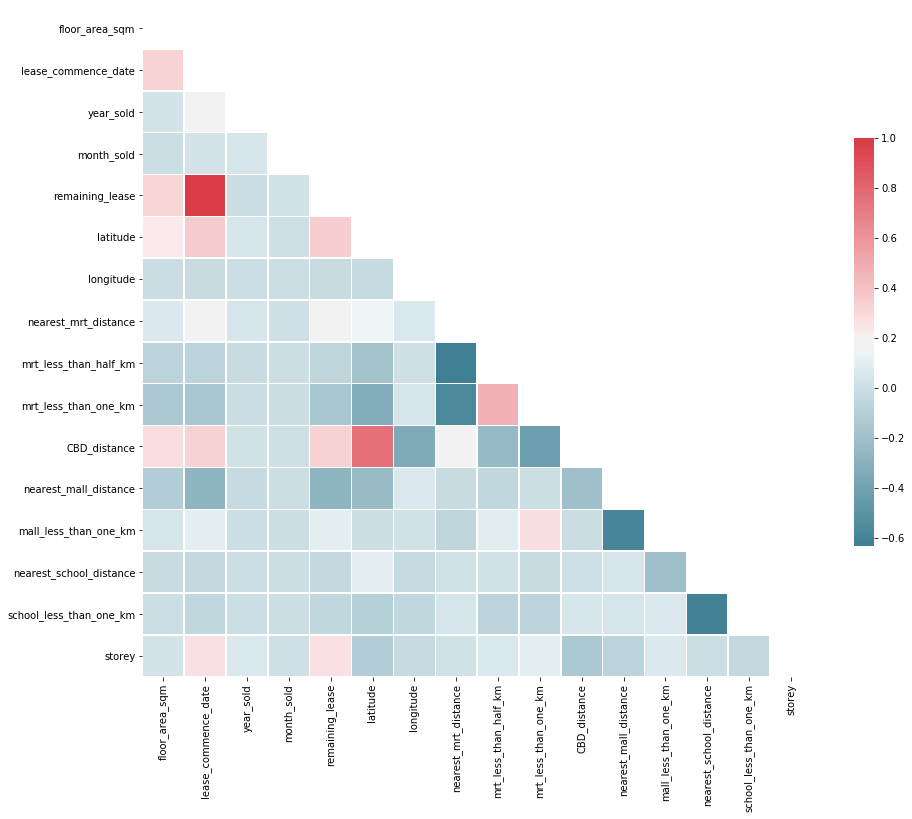

In [6]:
corr=round(X.corr(),2)
plt.figure(figsize=(15,15))
mask=np.triu(np.ones_like(corr,dtype=np.bool))
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr,square=True,annot=False,mask=mask,cmap=cmap,linewidths=0.5,cbar_kws={'shrink':0.5})
plt.show()

Based on the heatmap above, remaining_lease and lease_commence_date are highly correlated, thus only one of them will be considered as a feature to use in the model.

The final numerical features selected for modelling are as listed below.

In [7]:
num=df[["resale_price","floor_area_sqm","year_sold","month_sold","remaining_lease","nearest_mrt_distance","CBD_distance","nearest_mall_distance","nearest_school_distance","storey"]]
num.head()

,resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey
0,317000.0,73.0,2015,9,60,0.800629,9.142146,0.749952,1.31789,8.0
1,308000.0,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,8.0
2,318000.0,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,11.0
3,325000.0,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,5.0
4,310000.0,73.0,2017,3,58,0.800629,9.142146,0.749952,1.31789,8.0


### Categorical Features

Categorical features that display variance are considered for modelling. Boxplots are used to help determine this.

In [8]:
X_cat=X.select_dtypes(include="object").columns
X_cat

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'flat_model', 'date', 'address', 'mrt', 'mall', 'postcode', 'school'],
      dtype='object')

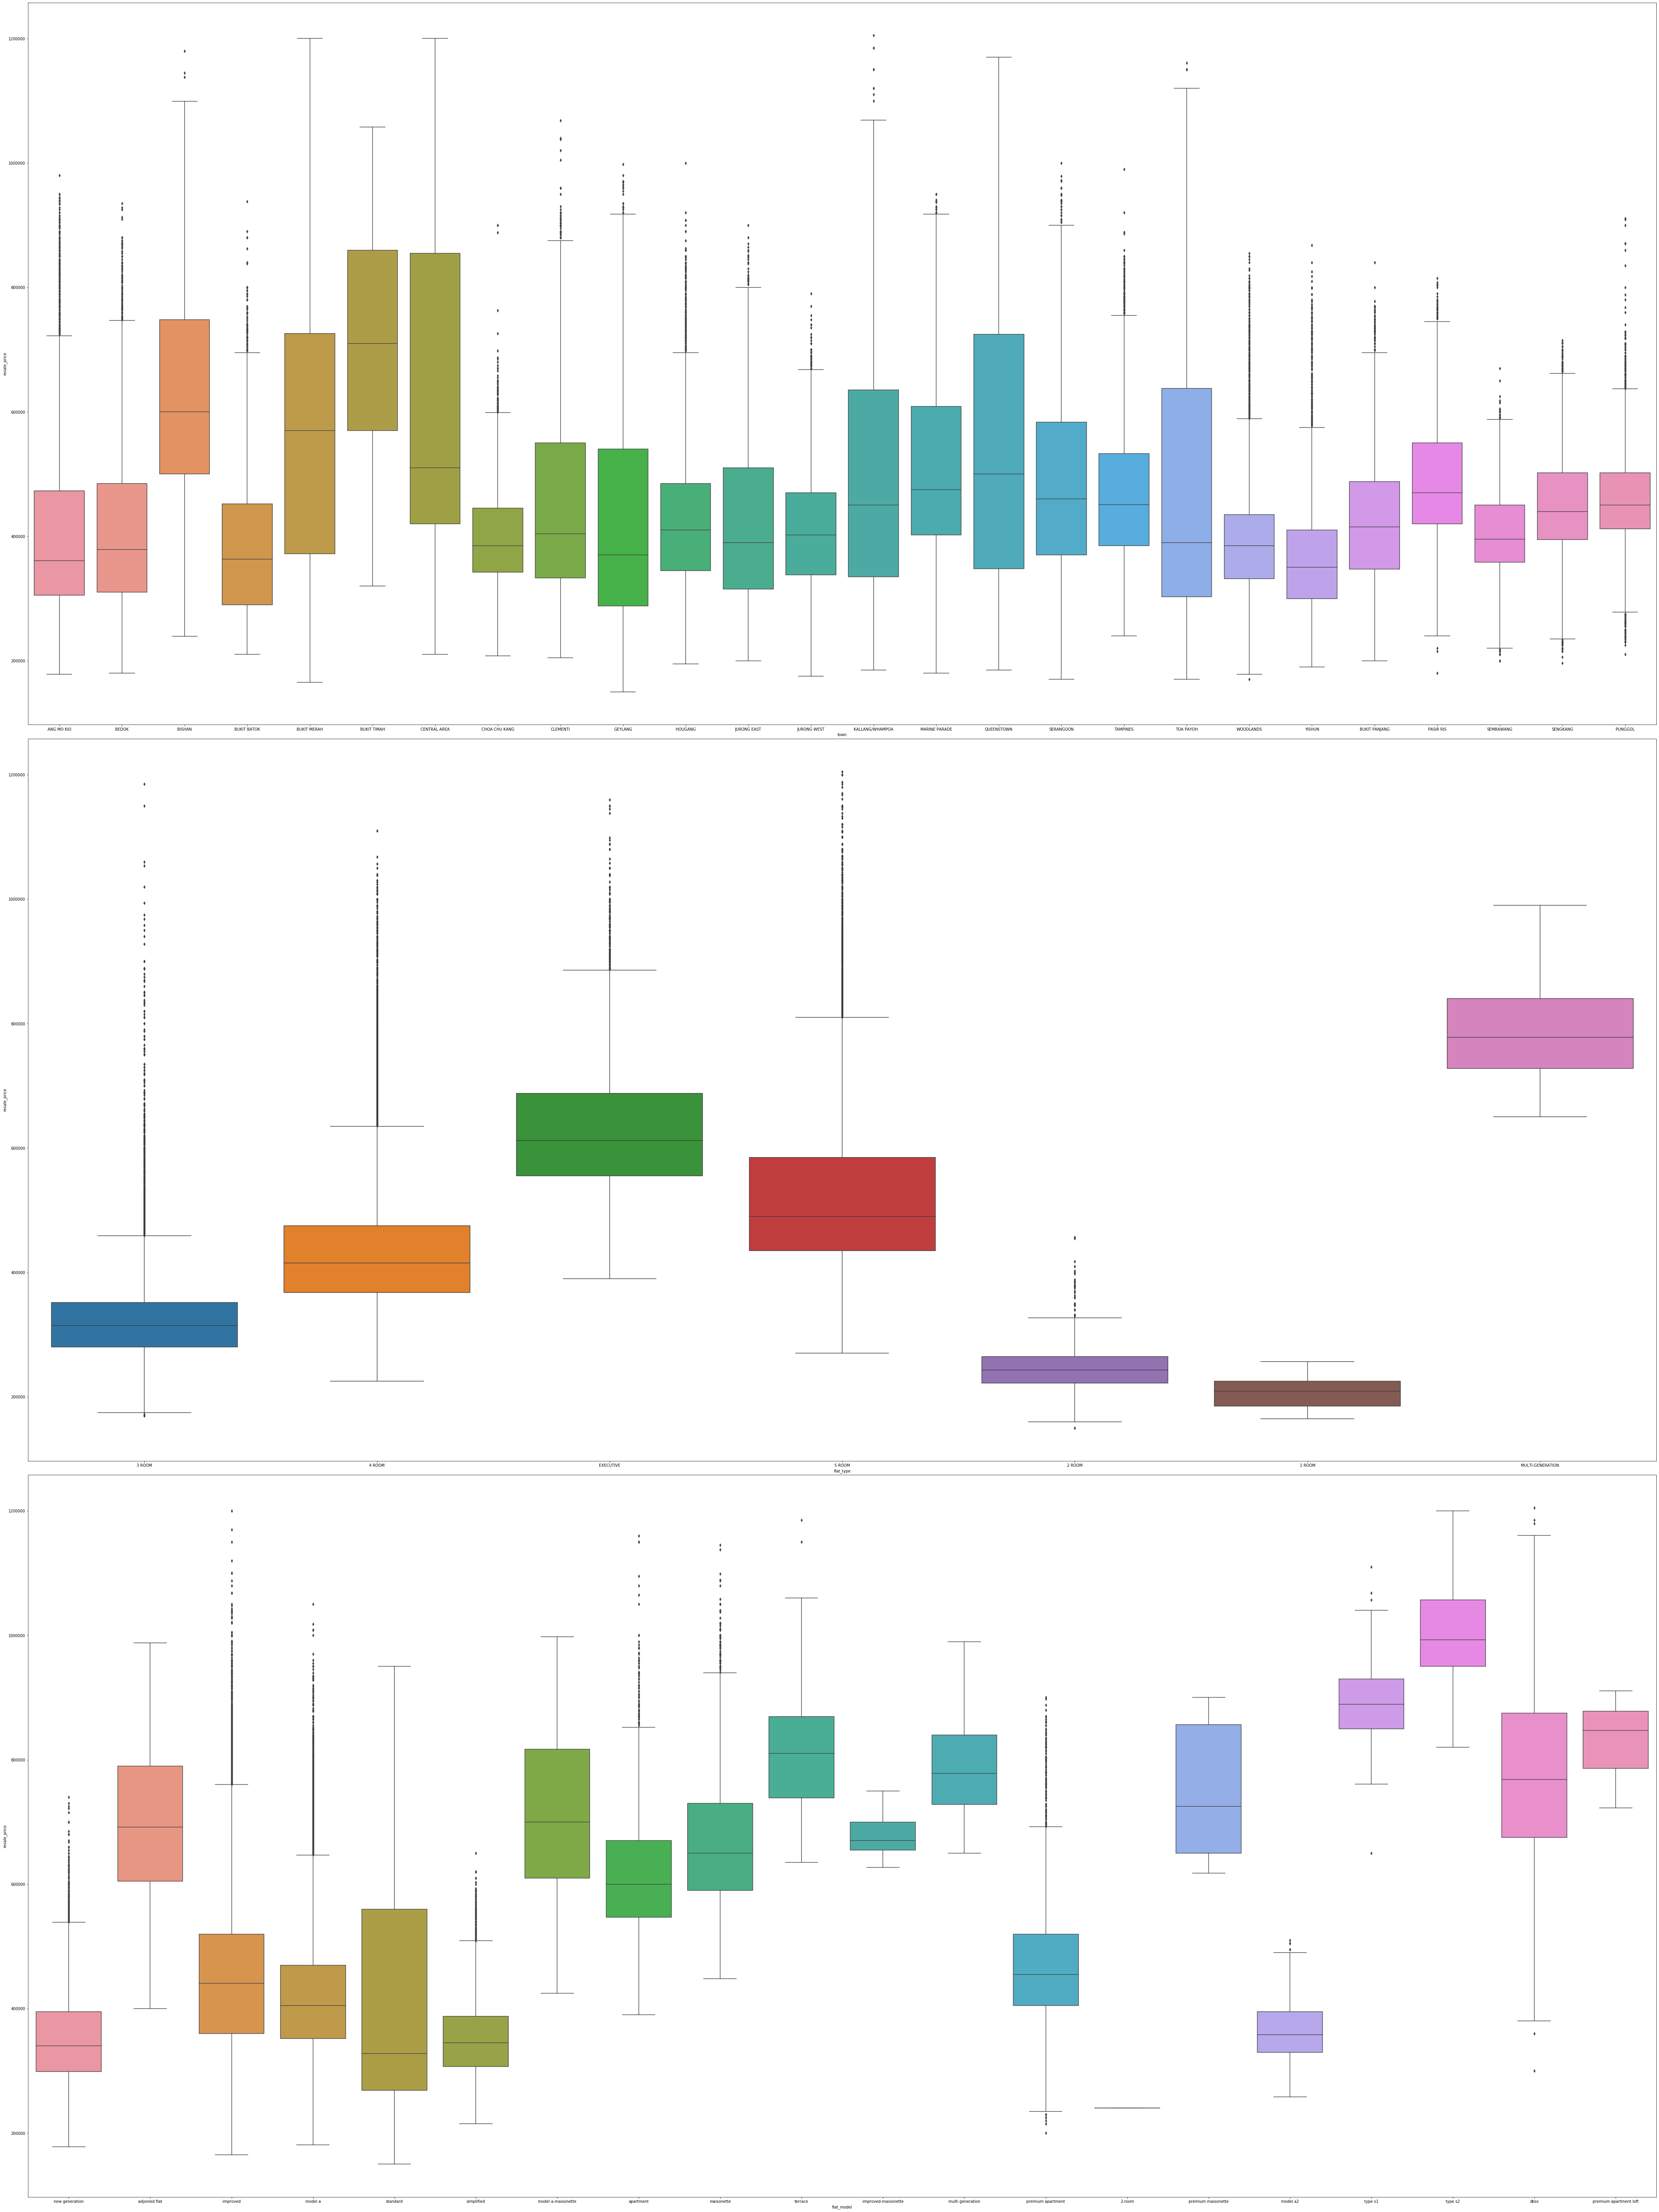

In [9]:
X_cat_list=["town","flat_type","flat_model"]
fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(60,80),sharey=True)
ax=ax.ravel()
for i in range(len(X_cat_list)):
    sns.boxplot(x=X_cat_list[i],y="resale_price",data=df,ax=ax[i])
plt.tight_layout(pad=0.5)

Since there are variance in the median resale price of town (first chart) , flat_type (2nd chart) and flat_model(3rd chart), these features are considered for modelling.

In [10]:
cat=df[["town","flat_type","flat_model"]]
cat.head()

,town,flat_type,flat_model
0,ANG MO KIO,3 ROOM,new generation
1,ANG MO KIO,3 ROOM,new generation
2,ANG MO KIO,3 ROOM,new generation
3,ANG MO KIO,3 ROOM,new generation
4,ANG MO KIO,3 ROOM,new generation


The final dataframe is obtained by putting together the numerical and categorical features.

In [11]:
df=pd.concat([num,cat],axis=1)
df.head()

,resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
0,317000.0,73.0,2015,9,60,0.800629,9.142146,0.749952,1.31789,8.0,ANG MO KIO,3 ROOM,new generation
1,308000.0,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,8.0,ANG MO KIO,3 ROOM,new generation
2,318000.0,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,11.0,ANG MO KIO,3 ROOM,new generation
3,325000.0,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,5.0,ANG MO KIO,3 ROOM,new generation
4,310000.0,73.0,2017,3,58,0.800629,9.142146,0.749952,1.31789,8.0,ANG MO KIO,3 ROOM,new generation


X represents the features of the model and y represents the target.

In [12]:
X=df.drop(["resale_price"],axis=1)
X.head()

,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
0,73.0,2015,9,60,0.800629,9.142146,0.749952,1.31789,8.0,ANG MO KIO,3 ROOM,new generation
1,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,8.0,ANG MO KIO,3 ROOM,new generation
2,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,11.0,ANG MO KIO,3 ROOM,new generation
3,73.0,2016,8,59,0.800629,9.142146,0.749952,1.31789,5.0,ANG MO KIO,3 ROOM,new generation
4,73.0,2017,3,58,0.800629,9.142146,0.749952,1.31789,8.0,ANG MO KIO,3 ROOM,new generation


In [13]:
y=df["resale_price"]
y.head()

0    317000.0
1    308000.0
2    318000.0
3    325000.0
4    310000.0
Name: resale_price, dtype: float64

### Process Data 

The data is split into the train set and test set, with the sets taking up 80% and 20% of the data respectively. To ensure that each town is sufficiently sampled within each set, the split is also stratified by town.

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=X["town"])

To prepare the data for modelling, numerical features undergo standard scalar and categorical features undergo one hot encoding. <br> 
The transformation of data is further streamlined by using the column transformer. <br>
Pipeline is used for better workflow and ease of deployment

In [15]:
num_features=["floor_area_sqm","year_sold","month_sold","remaining_lease","nearest_mrt_distance","CBD_distance",
              "nearest_mall_distance","nearest_school_distance","storey"]
num_transformer=Pipeline(steps=[("scaler",StandardScaler())])

In [16]:
cat_features=["town","flat_type","flat_model"]
cat_transformer=Pipeline(steps=[("encoder",OneHotEncoder(sparse=False,handle_unknown="ignore"))])

In [17]:
preprocessor=ColumnTransformer(transformers=[("num",num_transformer,num_features),("cat",cat_transformer,cat_features)])

### Modelling

As the adjusted r-squared score is used for model selection, a function to calculate the adjusted r-squared score is written.<br>Adjusted r-square will provide a better representation as it includes variables such as # of features and # of observations

In [18]:
def adjusted_r_squared(r_squared,n,p): 
    score=1-(1-(r_squared*r_squared))*((n-1)/(n-p-1))
    return score

Below is the function to train the model. <br>This function does gridsearch on the given parameter and uses a 10-fold cross validation. The best model is automatically refitted and it is saved for future use. The function returns the r-squared score, adjusted r-squared score, best parameters and coefficients of the model.

In [19]:
def train_model(model,model_name,parameter):
    
    search=GridSearchCV(pipe,parameter,n_jobs=-1,cv=10,verbose=1)
    search.fit(X_train,y_train)
    joblib.dump(search,"{}_model.pkl".format(model_name))
    
    num_column=["floor_area_sqm","year_sold","month_sold","remaining_lease","nearest_mrt_distance","CBD_distance","nearest_mall_distance","nearest_school_distance","storey"]
    cat_column=search.best_estimator_.named_steps["preprocessor"].transformers_[1][1]["encoder"].get_feature_names(cat_features).tolist()
    column_name=num_column+cat_column
    
    coef=search.best_estimator_.named_steps[model_name].coef_
    coefficient_df=pd.DataFrame(coef,index=column_name,columns=["coefficient"])
    coefficient_df=coefficient_df.sort_values("coefficient",ascending=False)
    
    rsquare=search.best_score_
    adj_rsquare=adjusted_r_squared(search.best_score_,X_train.shape[0],len(column_name))
    best_para=search.best_params_
    score_df=pd.DataFrame([rsquare,adj_rsquare,best_para],index=["r_squared","adjusted_r_squared","best_parameter"],columns=[model_name])
    
    print("r_squared={}".format(rsquare)) 
    print("adjusted_r_squared={}".format(adj_rsquare))
    print("best_parameter={}".format(best_para)) 
    print("\n")
    print(coefficient_df.to_string())
    
    return column_name,coefficient_df,score_df

In all models, the parameters were tuned iteratively until an optimal value was found.

### Ridge Model

In [20]:
ridge=Ridge()
ridge_parameter={"ridge__alpha":np.logspace(-1,0,50)}
pipe=Pipeline(steps=[("preprocessor",preprocessor),("ridge",ridge)])

In [21]:
ridge_column_name,ridge_coefficient_df,ridge_score_df=train_model(ridge,"ridge",ridge_parameter)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   32.2s finished


r_squared=0.8829670404005778
adjusted_r_squared=0.779505263112473
best_parameter={'ridge__alpha': 0.8685113737513525}


                                     coefficient
flat_model_terrace                 287464.102307
town_BUKIT TIMAH                   193100.691411
flat_model_type s2                 121209.460391
town_MARINE PARADE                 108842.387142
floor_area_sqm                      78676.195908
town_BISHAN                         77215.147031
flat_model_improved-maisonette      70382.957092
town_QUEENSTOWN                     60780.861047
flat_model_type s1                  59602.857950
town_CLEMENTI                       49929.976998
remaining_lease                     49357.070833
flat_model_premium apartment loft   45327.280127
flat_model_dbss                     41286.404791
flat_type_EXECUTIVE                 39781.339208
flat_model_multi generation         39154.108398
flat_type_MULTI-GENERATION          39154.108398
flat_model_model a-maisonette       26618.07525

### Lasso Model

In [22]:
lasso=Lasso()
lasso_parameter={"lasso__alpha":np.linspace(0.1,1,10)}
pipe=Pipeline(steps=[("preprocessor",preprocessor),("lasso",lasso)])

In [23]:
lasso_column_name,lasso_coefficient_df,lasso_score_df=train_model(lasso,"lasso",lasso_parameter)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 29.3min finished


r_squared=0.882965014049625
adjusted_r_squared=0.77950168267597
best_parameter={'lasso__alpha': 0.1}


                                     coefficient
flat_model_terrace                 369727.184735
town_BUKIT TIMAH                   216576.674827
flat_model_type s2                 200768.721936
flat_model_improved-maisonette     151400.237815
flat_model_type s1                 138343.238509
flat_type_MULTI-GENERATION         136678.954886
town_MARINE PARADE                 131873.330091
flat_model_premium apartment loft  127355.331703
flat_model_dbss                    119561.826959
flat_model_model a-maisonette      105071.075322
town_BISHAN                        100175.177097
town_QUEENSTOWN                     83699.876327
floor_area_sqm                      78550.853196
flat_model_premium maisonette       75210.451128
town_CLEMENTI                       72789.701015
flat_model_adjoined flat            67531.818078
flat_model_maisonette               52568.417542
remaining_lease

### Elasticnet Model

In [24]:
elasticnet=ElasticNet()
elasticnet_parameter={"elasticnet__alpha":np.linspace(0.1,1,10),"elasticnet__l1_ratio":np.linspace(0.1,0.9,9)}
pipe=Pipeline(steps=[("preprocessor",preprocessor),("elasticnet",elasticnet)])

In [25]:
elasticnet_column_name,elasticnet_coefficient_df,elasticnet_score_df=train_model(elasticnet,"elasticnet",elasticnet_parameter)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  4.4min finished


r_squared=0.8686465906142612
adjusted_r_squared=0.7544070792509574
best_parameter={'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}


                                    coefficient
floor_area_sqm                     90958.024236
flat_model_dbss                    50667.770064
remaining_lease                    47876.921218
town_BISHAN                        43575.489208
town_MARINE PARADE                 38303.550702
town_BUKIT TIMAH                   37079.158012
town_QUEENSTOWN                    36382.944984
town_CLEMENTI                      34511.731668
storey                             26091.165683
town_JURONG EAST                   24250.194019
flat_model_maisonette              23289.887976
town_JURONG WEST                   19306.630975
flat_model_terrace                 18058.492344
flat_type_EXECUTIVE                15964.307516
town_TAMPINES                      15843.013602
flat_model_type s1                 12392.483982
flat_model_type s2                 10775.345

In [45]:
ridge_score_df.join(lasso_score_df).join(elasticnet_score_df)

,ridge,lasso,elasticnet
r_squared,0.882967,0.882965,0.868647
adjusted_r_squared,0.779505,0.779502,0.754407
best_parameter,{'ridge__alpha': 0.8685113737513525},{'lasso__alpha': 0.1},"{'elasticnet__alpha': 0.1, 'elasticnet__l1_rat..."


The best model is the one with the highest adjusted r-squared score. Thus the ridge model with an alpha value of 0.8685113737513525 is selected as the final model. 

The final model is loaded and predictions are done on the test set. 

In [27]:
pipe=joblib.load("ridge_model.pkl")
y_pred=pipe.predict(X_test)

In [28]:
print("r_squared={}".format(pipe.score(X_test,y_test)))
print("adjusted_r_squared={}".format(adjusted_r_squared(pipe.score(X_test,y_test),X_test.shape[0],len(ridge_column_name))))
print("rmse={}".format(mean_squared_error(y_test,y_pred,squared=False)))
print("\n")
print(ridge_coefficient_df.to_string())

r_squared=0.8817680147276418
adjusted_r_squared=0.7770070078393684
rmse=49204.995221911064


                                     coefficient
flat_model_terrace                 287464.102307
town_BUKIT TIMAH                   193100.691411
flat_model_type s2                 121209.460391
town_MARINE PARADE                 108842.387142
floor_area_sqm                      78676.195908
town_BISHAN                         77215.147031
flat_model_improved-maisonette      70382.957092
town_QUEENSTOWN                     60780.861047
flat_model_type s1                  59602.857950
town_CLEMENTI                       49929.976998
remaining_lease                     49357.070833
flat_model_premium apartment loft   45327.280127
flat_model_dbss                     41286.404791
flat_type_EXECUTIVE                 39781.339208
flat_model_multi generation         39154.108398
flat_type_MULTI-GENERATION          39154.108398
flat_model_model a-maisonette       26618.075253
storey                   

**Based on the test set, the model has an r-squared score of 0.88, adjusted r_squared score of 0.77 and root mean square error of 49205.** 

We are also able to infer from the coefficients that for example, a unit with terrace flat model increases the resale price by 287464 and a unit with improved flat model decreases the resale price by 91821.

### Model Review

Let's take a look at the residual plot for the test set.

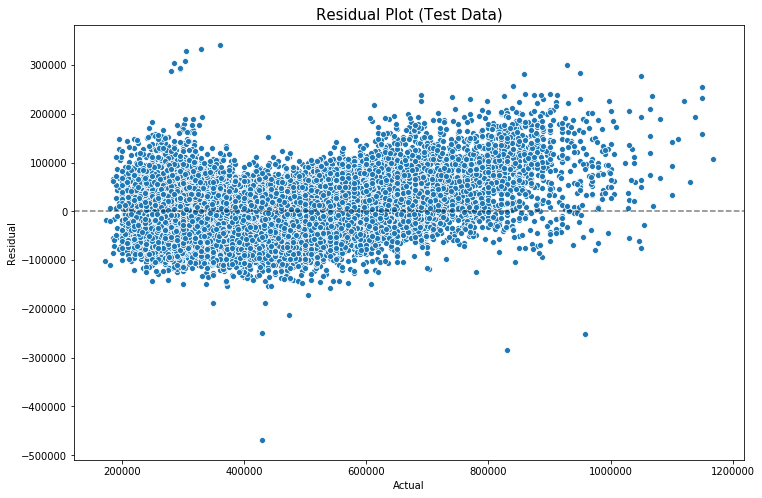

In [29]:
residual=y_test-pipe.predict(X_test)
plt.figure(figsize=(12,8))
sns.scatterplot(y_test,residual)
plt.title("Residual Plot (Test Data)",fontsize=15)
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.axhline(0,ls="--",color="k",alpha=0.5);

A deeper look at the data points with residual more than or equal to 250000 or less than or equal to -250000 show that the model actually predicted negative resale price for a number of these points.

In [30]:
y_test_df=pd.DataFrame(data=y_test)
y_test_df["predicted_resale_price"]=pipe.predict(X_test)
residual_test_df=pd.DataFrame(data=residual)
residual_test_df=residual_test_df.rename(columns={"resale_price":"residual"})

residual_test_df['residual'].describe()

count     26787.000000
mean        227.731935
std       49205.386686
min     -468856.832905
25%      -32016.717902
50%       -4086.913568
75%       26536.431407
max      341530.098385
Name: residual, dtype: float64

In [31]:
residual_test_df=residual_test_df[(residual_test_df["residual"]>=250000)|(residual_test_df["residual"]<=-250000)]
residual_test_df=residual_test_df.join(y_test_df).join(X_test)
residual_test_df

,residual,resale_price,predicted_resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
85018,331957.871898,330000.0,-1.957872e+03,74.0,2018,2,62,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
85013,303704.418172,286000.0,-1.770442e+04,66.0,2017,1,63,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
76198,254487.087658,1150000.0,8.955129e+05,147.0,2019,7,75,0.210535,5.347680,0.608448,2.971705,20.0,QUEENSTOWN,EXECUTIVE,apartment
85024,292391.736685,295000.0,2.608263e+03,66.0,2013,5,67,3.498204,19.005036,3.169403,6.973344,2.0,PASIR RIS,3 ROOM,improved
85029,292887.196545,295000.0,2.112803e+03,66.0,2014,11,66,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
103734,299521.555857,928000.0,6.284784e+05,111.0,2019,8,80,0.202830,4.320159,0.888145,3.064218,8.0,GEYLANG,5 ROOM,improved
14376,-284376.982686,830000.0,1.114377e+06,215.0,2017,6,54,1.040233,4.763723,1.105361,1.153623,2.0,KALLANG/WHAMPOA,3 ROOM,terrace
85027,308051.678050,303000.0,-5.051678e+03,66.0,2014,3,66,3.498204,19.005036,3.169403,6.973344,2.0,PASIR RIS,3 ROOM,improved
123707,277197.061883,1050000.0,7.728029e+05,113.0,2019,7,93,0.447544,2.445989,0.476929,3.128718,14.0,BUKIT MERAH,5 ROOM,improved
64104,256150.177647,840000.0,5.838498e+05,120.0,2017,8,71,0.263368,8.006358,1.939405,0.864873,11.0,BEDOK,5 ROOM,improved


So which towns are the model not able to predict accurately? Turns out that Pasir Ris has the most number of predicted value far off from the actual value. In fact, these units are all 3 room improved and on a low level. 

In [32]:
residual_test_df["town"].value_counts()

PASIR RIS          8
BEDOK              2
QUEENSTOWN         2
KALLANG/WHAMPOA    2
GEYLANG            1
ANG MO KIO         1
BUKIT MERAH        1
Name: town, dtype: int64

In [33]:
residual_test_df[residual_test_df["town"]=="PASIR RIS"]

,residual,resale_price,predicted_resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
85018,331957.871898,330000.0,-1957.871898,74.0,2018,2,62,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
85013,303704.418172,286000.0,-17704.418172,66.0,2017,1,63,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
85024,292391.736685,295000.0,2608.263315,66.0,2013,5,67,3.498204,19.005036,3.169403,6.973344,2.0,PASIR RIS,3 ROOM,improved
85029,292887.196545,295000.0,2112.803455,66.0,2014,11,66,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
85027,308051.678050,303000.0,-5051.678050,66.0,2014,3,66,3.498204,19.005036,3.169403,6.973344,2.0,PASIR RIS,3 ROOM,improved
85023,341530.098385,360000.0,18469.901615,66.0,2013,2,67,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved
84579,286648.206152,280000.0,-6648.206152,66.0,2015,2,64,3.524741,19.075844,3.190118,7.043016,5.0,PASIR RIS,3 ROOM,improved
85016,329029.623114,305000.0,-24029.623114,66.0,2017,9,63,3.498204,19.005036,3.169403,6.973344,5.0,PASIR RIS,3 ROOM,improved


### Model Limitation

Since the output of linear model is unbounded, our model therefore predicted negative values for the cheaper resale units, like in the case of low level 3 room improved units in Pasir Ris.

### Model Improvement

To improve the model's performance, log transformation is one option. The target is log transformed before fitting and the exponential is applied to the output for predictions.

Here is the function for the updated model.

In [34]:
def new_train_model(model,model_name,parameter):
    
    search=GridSearchCV(pipe,parameter,n_jobs=-1,cv=10,verbose=1)
    search.fit(X_train,np.log(y_train))
    joblib.dump(search,"new_{}_model.pkl".format(model_name))
    
    num_column=["floor_area_sqm","year_sold","month_sold","remaining_lease","nearest_mrt_distance","CBD_distance","nearest_mall_distance","nearest_school_distance","storey"]
    cat_column=search.best_estimator_.named_steps["preprocessor"].transformers_[1][1]["encoder"].get_feature_names(cat_features).tolist()
    new_column_name=num_column+cat_column
    
    coef=search.best_estimator_.named_steps[model_name].coef_
    coefficient_df=pd.DataFrame(coef,index=new_column_name,columns=["coefficient"])
    new_coefficient_df=coefficient_df.sort_values("coefficient",ascending=False)
    
    rsquare=search.best_score_
    adj_rsquare=adjusted_r_squared(search.best_score_,X_train.shape[0],len(new_column_name))
    best_para=search.best_params_
    new_score_df=pd.DataFrame([rsquare,adj_rsquare,best_para],index=["r_squared","adjusted_r_squared","best_parameter"],columns=[model_name])
    
    print("r_squared={}".format(rsquare)) 
    print("adjusted_r_squared={}".format(adj_rsquare))
    print("best_parameter={}".format(best_para)) 
    print("\n")
    print(new_coefficient_df.to_string())
    
    return new_column_name,new_coefficient_df,new_score_df

In [35]:
ridge=Ridge()
ridge_parameter={"ridge__alpha":np.logspace(-1,0,50)}
pipe=Pipeline(steps=[("preprocessor",preprocessor),("ridge",ridge)])

In [36]:
new_column_name,new_coefficient_df,new_score_df=new_train_model(ridge,"ridge",ridge_parameter)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   28.4s finished


r_squared=0.9030622152015833
adjusted_r_squared=0.8154162779415718
best_parameter={'ridge__alpha': 0.6866488450043}


                                   coefficient
flat_model_terrace                    0.567066
town_BUKIT TIMAH                      0.329890
town_MARINE PARADE                    0.239295
flat_model_improved-maisonette        0.173142
floor_area_sqm                        0.167802
flat_type_EXECUTIVE                   0.140198
town_BISHAN                           0.134945
flat_type_5 ROOM                      0.116655
town_QUEENSTOWN                       0.115486
town_CLEMENTI                         0.104526
remaining_lease                       0.102814
flat_model_multi generation           0.087805
flat_type_MULTI-GENERATION            0.087805
flat_type_4 ROOM                      0.083130
flat_model_dbss                       0.061199
flat_model_model a-maisonette         0.053738
storey                                0.045721
town_JURONG EAST                    

Using the same train data, the r-squared and adjusted r-squared scores both increased.

Let's test out this new model on the test data.

In [37]:
pipe=joblib.load("new_ridge_model.pkl")
y_pred=np.exp(pipe.predict(X_test))

In [38]:
print("r_squared={}".format(pipe.score(X_test,np.log(y_test))))
print("adjusted_r_squared={}".format(adjusted_r_squared(pipe.score(X_test,np.log(y_test)),X_test.shape[0],len(new_column_name))))
print("rmse={}".format(mean_squared_error(y_test,y_pred,squared=False)))
print("\n")
print(new_coefficient_df.to_string())

r_squared=0.9017852540619676
adjusted_r_squared=0.8127903101240962
rmse=45441.669685777706


                                   coefficient
flat_model_terrace                    0.567066
town_BUKIT TIMAH                      0.329890
town_MARINE PARADE                    0.239295
flat_model_improved-maisonette        0.173142
floor_area_sqm                        0.167802
flat_type_EXECUTIVE                   0.140198
town_BISHAN                           0.134945
flat_type_5 ROOM                      0.116655
town_QUEENSTOWN                       0.115486
town_CLEMENTI                         0.104526
remaining_lease                       0.102814
flat_model_multi generation           0.087805
flat_type_MULTI-GENERATION            0.087805
flat_type_4 ROOM                      0.083130
flat_model_dbss                       0.061199
flat_model_model a-maisonette         0.053738
storey                                0.045721
town_JURONG EAST                      0.044351
town_SERANGOON

The r-squared score increased to 0.90, adjusted r-squared score increased to 0.81 and the root mean square error reduced to 45441. Using a log transformation did help to improve the model.

Based on the ratio, we expect to see 76% increase in resale price for units with flat model terrace and a 39% increase in resale price for units that are located in Bukit Timah. 

### Model Review

The new residual plot clearly shows the data points randomly dispersed around the horizontal axis, implying that the linear regression model is appropriate for the data.

What are the points that are far off?

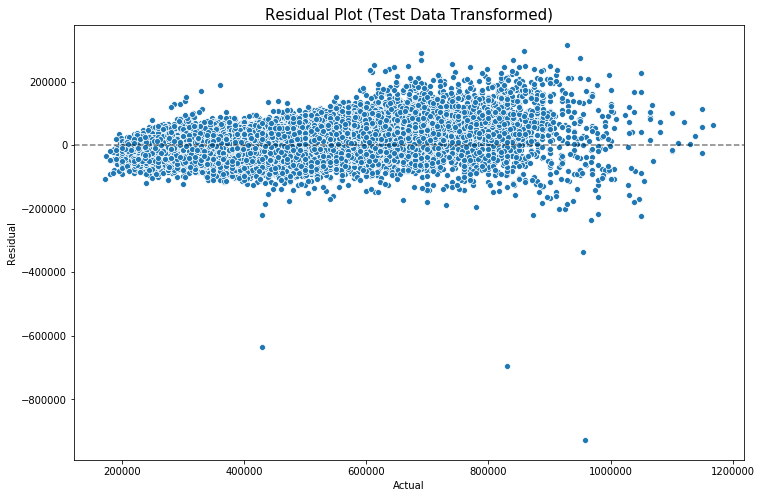

In [39]:
residual=y_test-np.exp(pipe.predict(X_test))
plt.figure(figsize=(12,8))
sns.scatterplot(y_test,residual)
plt.title("Residual Plot (Test Data Transformed)",fontsize=15)
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.axhline(0,ls="--",color="k",alpha=0.5);

In [40]:
y_test_df=pd.DataFrame(data=y_test)
y_test_df["predicted_resale_price"]=np.exp(pipe.predict(X_test))
residual_test_df=pd.DataFrame(data=residual)
residual_test_df=residual_test_df.rename(columns={"resale_price":"residual"})
residual_test_df=residual_test_df[(residual_test_df["residual"]>=250000)|(residual_test_df["residual"]<=-250000)]
residual_test_df=residual_test_df.join(y_test_df).join(X_test)
residual_test_df

,residual,resale_price,predicted_resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
72625,267193.332550,690000.0,4.228067e+05,75.0,2013,9,59,0.373832,2.202298,0.513901,2.735088,2.0,BUKIT MERAH,3 ROOM,standard
103734,315964.344392,928000.0,6.120357e+05,111.0,2019,8,80,0.202830,4.320159,0.888145,3.064218,8.0,GEYLANG,5 ROOM,improved
14376,-695539.926818,830000.0,1.525540e+06,215.0,2017,6,54,1.040233,4.763723,1.105361,1.153623,2.0,KALLANG/WHAMPOA,3 ROOM,terrace
65379,254544.514001,740000.0,4.854555e+05,108.0,2018,10,70,0.295552,7.920138,1.887243,0.778593,8.0,BEDOK,4 ROOM,model a
64104,268522.603850,840000.0,5.714774e+05,120.0,2017,8,71,0.263368,8.006358,1.939405,0.864873,11.0,BEDOK,5 ROOM,improved
121541,294984.635205,858000.0,5.630154e+05,112.0,2018,11,91,1.240009,10.326882,0.269487,0.917744,5.0,BEDOK,5 ROOM,improved
58219,-928368.302522,958000.0,1.886368e+06,241.0,2015,6,56,1.101772,4.888373,1.181388,1.047479,2.0,KALLANG/WHAMPOA,3 ROOM,terrace
122963,275097.885822,950000.0,6.749021e+05,121.0,2018,9,93,0.813420,8.939569,0.690203,1.092724,11.0,ANG MO KIO,5 ROOM,improved
29507,250971.136217,613000.0,3.620289e+05,60.0,2015,5,57,0.476835,2.266793,0.514562,2.914952,2.0,BUKIT MERAH,3 ROOM,standard
120613,-635304.074436,430000.0,1.065304e+06,117.0,2016,10,95,0.358999,7.247784,0.522762,2.028043,38.0,QUEENSTOWN,5 ROOM,improved


In [41]:
residual_test_df["town"].value_counts()

BEDOK              3
BUKIT MERAH        3
KALLANG/WHAMPOA    2
BISHAN             1
GEYLANG            1
QUEENSTOWN         1
ANG MO KIO         1
Name: town, dtype: int64

In [60]:
df[(df["floor_area_sqm"]==117.0)&(df["year_sold"]==2016)&(df["town"]=="QUEENSTOWN")&(df["flat_type"]=="5 ROOM")&(df["flat_model"]=="improved")]

,resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
120608,850000.0,117.0,2016,3,95,0.358999,7.247784,0.522762,2.028043,5.0,QUEENSTOWN,5 ROOM,improved
120609,945000.0,117.0,2016,4,95,0.358999,7.247784,0.522762,2.028043,20.0,QUEENSTOWN,5 ROOM,improved
120610,920000.0,117.0,2016,5,95,0.358999,7.247784,0.522762,2.028043,17.0,QUEENSTOWN,5 ROOM,improved
120611,968000.0,117.0,2016,5,95,0.358999,7.247784,0.522762,2.028043,32.0,QUEENSTOWN,5 ROOM,improved
120612,855000.0,117.0,2016,6,95,0.358999,7.247784,0.522762,2.028043,5.0,QUEENSTOWN,5 ROOM,improved
120613,430000.0,117.0,2016,10,95,0.358999,7.247784,0.522762,2.028043,38.0,QUEENSTOWN,5 ROOM,improved
120670,955000.0,117.0,2016,3,95,0.358954,7.145111,0.572326,1.973977,29.0,QUEENSTOWN,5 ROOM,improved
121254,888000.0,117.0,2016,7,94,0.564182,4.595282,0.884764,3.006576,11.0,QUEENSTOWN,5 ROOM,improved
121255,950000.0,117.0,2016,9,94,0.564182,4.595282,0.884764,3.006576,29.0,QUEENSTOWN,5 ROOM,improved
121256,920000.0,117.0,2016,11,94,0.564182,4.595282,0.884764,3.006576,14.0,QUEENSTOWN,5 ROOM,improved


### Model Limitation 

In general, the model is not good at predicting units with a large floor area of around 110sqm or more. 

Also, the outliers in the dataset are affecting the model's accuracy. For example, the resale price of the Queenstown unit is clearly far off the resale price of similar units ( row 120613 vs row 65379 ) 

### Random Forest

Another way is to try out more powerful models such as random forest.

In [47]:
RandomForest=RandomForestRegressor()
RandomForest_parameter={"RandomForest__max_depth":[100,125,150], #reduce to prevent overfit
                        "RandomForest__n_estimators":[200,300], #increase to prevent overfit
                        "RandomForest__min_samples_split":[3,4],
                        "RandomForest__min_samples_leaf":[1,2] #increase to prevent overfit
                        }
pipe=Pipeline(steps=[("preprocessor",preprocessor),("RandomForest",RandomForest)])

In [48]:
search=GridSearchCV(pipe,RandomForest_parameter,n_jobs=-1,cv=10,verbose=1)
search.fit(X_train,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 107.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 142.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                       

In [50]:
num_column=["floor_area_sqm","year_sold","month_sold","remaining_lease","nearest_mrt_distance","CBD_distance","nearest_mall_distance","nearest_school_distance","storey"]
cat_column=search.best_estimator_.named_steps["preprocessor"].transformers_[1][1]["encoder"].get_feature_names(cat_features).tolist()
column_name=num_column+cat_column
    
feature_importance=search.best_estimator_[1][1].feature_importances_
feature_importance_df=pd.DataFrame(abs(feature_importance),index=column_name,columns=["feature_importance"])
feature_importance_df=feature_importance_df.sort_values("feature_importance",ascending=False)
    
rsquare=search.best_score_
adj_rsquare=adjusted_r_squared(search.best_score_,X_train.shape[0],len(column_name))
best_para=search.best_params_
score_df=pd.DataFrame([rsquare,adj_rsquare,best_para],index=["r_squared","adjusted_r_squared","best_parameter"],columns=["RandomForest"])
    
print("r_squared={}".format(rsquare)) 
print("adjusted_r_squared={}".format(adj_rsquare))
print("best_parameter={}".format(best_para)) 
print("\n")
print(feature_importance_df.to_string())

r_squared=0.9717884183209342
adjusted_r_squared=0.9443410424123518
best_parameter={'RandomForest__max_depth': 100, 'RandomForest__min_samples_leaf': 1, 'RandomForest__min_samples_split': 4, 'RandomForest__n_estimators': 300}


                                   feature_importance
floor_area_sqm                               0.468233
CBD_distance                                 0.286354
remaining_lease                              0.063497
nearest_mrt_distance                         0.030202
flat_type_4 ROOM                             0.025926
storey                                       0.023105
year_sold                                    0.022479
nearest_mall_distance                        0.018453
nearest_school_distance                      0.012760
flat_model_dbss                              0.006271
flat_type_5 ROOM                             0.005609
month_sold                                   0.004578
flat_type_EXECUTIVE                          0.003401
town_BUKIT TIMAH 

The model achieved an adjusted r squared score of 0.94 for the train set. 

In [53]:
joblib.dump(search,"randomforest_model.pkl")
pipe=joblib.load("randomforest_model.pkl")
y_pred=pipe.predict(X_test)

In [54]:
print("r_squared={}".format(pipe.score(X_test,y_test)))
print("adjusted_r_squared={}".format(adjusted_r_squared(pipe.score(X_test,y_test),X_test.shape[0],len(new_column_name))))
print("rmse={}".format(mean_squared_error(y_test,y_pred,squared=False)))
print("\n")
print(feature_importance_df.to_string())

r_squared=0.9712270888859684
adjusted_r_squared=0.9431525990857946
rmse=24273.56724662202


                                   feature_importance
floor_area_sqm                               0.468233
CBD_distance                                 0.286354
remaining_lease                              0.063497
nearest_mrt_distance                         0.030202
flat_type_4 ROOM                             0.025926
storey                                       0.023105
year_sold                                    0.022479
nearest_mall_distance                        0.018453
nearest_school_distance                      0.012760
flat_model_dbss                              0.006271
flat_type_5 ROOM                             0.005609
month_sold                                   0.004578
flat_type_EXECUTIVE                          0.003401
town_BUKIT TIMAH                             0.003189
town_CLEMENTI                                0.002400
town_QUEENSTOWN                             

For the test set, it achieved an adjusted r squared score of 0.94 as well.

The top 3 feature importance are floor area, CBD distance and remaining lease.

### Model Review

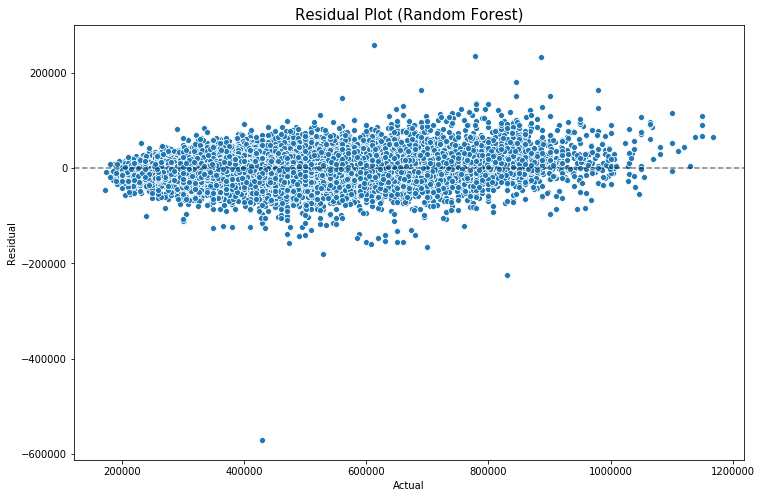

In [55]:
residual=y_test-pipe.predict(X_test)
plt.figure(figsize=(12,8))
sns.scatterplot(y_test,residual)
plt.title("Residual Plot (Random Forest)",fontsize=15)
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.axhline(0,ls="--",color="k",alpha=0.5);

In [56]:
y_test_df=pd.DataFrame(data=y_test)
y_test_df["predicted_resale_price"]=pipe.predict(X_test)
residual_test_df=pd.DataFrame(data=residual)
residual_test_df=residual_test_df.rename(columns={"resale_price":"residual"})
residual_test_df=residual_test_df[(residual_test_df["residual"]>=250000)|(residual_test_df["residual"]<=-250000)]
residual_test_df=residual_test_df.join(y_test_df).join(X_test)
residual_test_df

,residual,resale_price,predicted_resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
29507,258675.727058,613000.0,3.543243e+05,60.0,2015,5,57,0.476835,2.266793,0.514562,2.914952,2.0,BUKIT MERAH,3 ROOM,standard
120613,-570880.682942,430000.0,1.000881e+06,117.0,2016,10,95,0.358999,7.247784,0.522762,2.028043,38.0,QUEENSTOWN,5 ROOM,improved


In [59]:
df[(df["floor_area_sqm"]==60.0)&(df["year_sold"]==2015)&(df["town"]=="BUKIT MERAH")&(df["flat_type"]=="3 ROOM")&(df["flat_model"]=="standard")]

,resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
7175,322000.0,60.0,2015,3,51,0.882761,4.670659,0.468532,3.828046,2.0,BUKIT MERAH,3 ROOM,standard
7177,308000.0,60.0,2015,4,51,0.882761,4.670659,0.468532,3.828046,8.0,BUKIT MERAH,3 ROOM,standard
7178,288000.0,60.0,2015,7,51,0.882761,4.670659,0.468532,3.828046,2.0,BUKIT MERAH,3 ROOM,standard
7179,330000.0,60.0,2015,9,51,0.882761,4.670659,0.468532,3.828046,8.0,BUKIT MERAH,3 ROOM,standard
7229,363000.0,60.0,2015,1,53,0.226269,2.596804,0.236929,2.861411,5.0,BUKIT MERAH,3 ROOM,standard
7230,388000.0,60.0,2015,12,53,0.226269,2.596804,0.236929,2.861411,8.0,BUKIT MERAH,3 ROOM,standard
29507,613000.0,60.0,2015,5,57,0.476835,2.266793,0.514562,2.914952,2.0,BUKIT MERAH,3 ROOM,standard
39659,340000.0,60.0,2015,3,53,0.701598,2.893296,0.703218,3.631465,8.0,BUKIT MERAH,3 ROOM,standard


In [58]:
df[(df["floor_area_sqm"]==117.0)&(df["year_sold"]==2016)&(df["town"]=="QUEENSTOWN")&(df["flat_type"]=="5 ROOM")&(df["flat_model"]=="improved")]

,resale_price,floor_area_sqm,year_sold,month_sold,remaining_lease,nearest_mrt_distance,CBD_distance,nearest_mall_distance,nearest_school_distance,storey,town,flat_type,flat_model
120608,850000.0,117.0,2016,3,95,0.358999,7.247784,0.522762,2.028043,5.0,QUEENSTOWN,5 ROOM,improved
120609,945000.0,117.0,2016,4,95,0.358999,7.247784,0.522762,2.028043,20.0,QUEENSTOWN,5 ROOM,improved
120610,920000.0,117.0,2016,5,95,0.358999,7.247784,0.522762,2.028043,17.0,QUEENSTOWN,5 ROOM,improved
120611,968000.0,117.0,2016,5,95,0.358999,7.247784,0.522762,2.028043,32.0,QUEENSTOWN,5 ROOM,improved
120612,855000.0,117.0,2016,6,95,0.358999,7.247784,0.522762,2.028043,5.0,QUEENSTOWN,5 ROOM,improved
120613,430000.0,117.0,2016,10,95,0.358999,7.247784,0.522762,2.028043,38.0,QUEENSTOWN,5 ROOM,improved
120670,955000.0,117.0,2016,3,95,0.358954,7.145111,0.572326,1.973977,29.0,QUEENSTOWN,5 ROOM,improved
121254,888000.0,117.0,2016,7,94,0.564182,4.595282,0.884764,3.006576,11.0,QUEENSTOWN,5 ROOM,improved
121255,950000.0,117.0,2016,9,94,0.564182,4.595282,0.884764,3.006576,29.0,QUEENSTOWN,5 ROOM,improved
121256,920000.0,117.0,2016,11,94,0.564182,4.595282,0.884764,3.006576,14.0,QUEENSTOWN,5 ROOM,improved


The 2 data points in residual_test_df are clearly outliers in the dataset, thus resulting in our model not being able to make an accurate prediction of these 2 points.

### Model Limitation

The feature importance obtained are not explainable for a random forest model.

# Deployment

Finally, the model is deployed using AWS.

Deployed at AWS : http://ec2-54-179-165-223.ap-southeast-1.compute.amazonaws.com:8501/ <br>
Code : https://github.com/andrewng88/hdb/blob/master/app.py

# Conclusion

1. The random forest model predicted the resale price of hdb units in Singapore with an R2 of 0.94.
2. The random forest model is deployed for use.

# Moving forward

1. Obtaining more data such as transaction that is contrained by racial quota of seller/buyer could help to provide greater insights to improve the accuracy of the model.<br>
2. For deployment, produce POI( Point of Interest) based on postal code.

# The end


Project is done by <br>**Andrew Ng** https://www.linkedin.com/in/sc-ng-andrew/ and<br>
**Lau Lee Ling** https://www.linkedin.com/in/lauleeling/